# CNN model to detect anc localise sources

## Collect source and background datasets

In [36]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# info tables
src_info = f'/data01/homes/dipiano/E4/z60_NLST/crab/sim/merged_data.dat'
bkg_info = f'/data01/homes/dipiano/E4/z60_NLST/background/sim/merged_data.dat'

# dataset 
mapsname = '/data01/homes/dipiano/E4/z60_NLST/ds_50s_5sgm_1000sz.npy'
ds = np.load(mapsname, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
print(f"Maps: {ds.keys()}")
print(f"SRC dataset size: {len(ds['SRC'])}")
print(f"BKG dataset size: {len(ds['BKG'])}")

Maps: dict_keys(['SRC', 'BKG'])
SRC dataset size: 1000
BKG dataset size: 1000


### Split train and test datasets

In [30]:
from astroai.tools.utils import split_dataset

train_data, train_labels, test_data, test_labels = split_dataset(ds, split=80, reshape=True, binning=250)

print(f"Train dataset: {len(train_data)}, {train_data.shape}")
print(f"Train labels: {len(train_labels)}, {train_labels.shape}")
print(f"\nTest dataset: {len(test_data)}, {test_data.shape}")
print(f"Test labels: {len(test_labels)}, {test_labels.shape}")

assert all(train_labels[:int(len(train_labels)/2)]) == 1
assert all(train_labels[int(len(train_labels)/2):]) == 0
assert all(test_labels[:int(len(test_labels)/2)]) == 1
assert all(test_labels[int(len(test_labels)/2):]) == 0

Train dataset: 1600, (1600, 250, 250, 1)
Train labels: 1600, (1600, 1)

Test dataset: 400, (400, 250, 250, 1)
Test labels: 400, (400, 1)


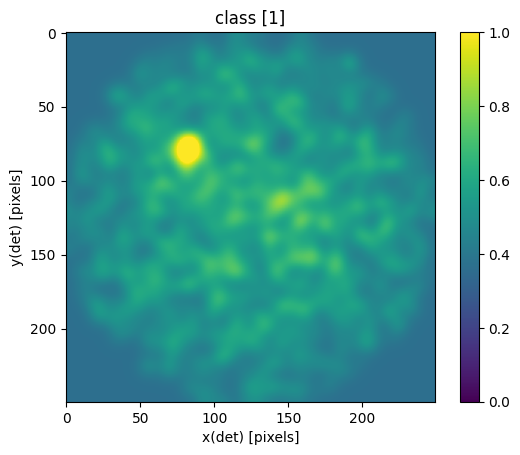

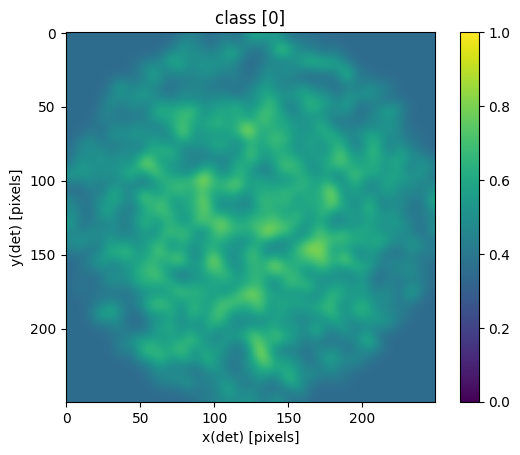

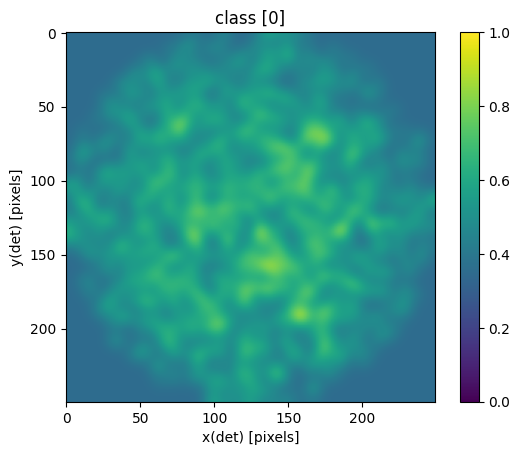

In [27]:
from astroai.tools.utils import plot_heatmap

idx = 802
plot_heatmap(train_data[0], title=f'class {train_labels[0]}', show=True, save=False, save_name=None)
plot_heatmap(train_data[-1], title=f'class {train_labels[-1]}', show=True, save=False, save_name=None)
plot_heatmap(train_data[idx], title=f'class {train_labels[idx]}', show=True, save=False, save_name=None)

## Load TensorBoard

In [15]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Create CNN Model

In [16]:
import tensorflow as tf
TF_CPP_MIN_LOG_LEVEL="1"

# seed
tf.random.set_seed(42)
np.random.seed(42)

# create TF dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

# create model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(2, (5, 5), activation='relu', input_shape=(250, 250, 1), name='conv2d_1'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), name='maxpool2d_1'))
model.add(tf.keras.layers.Conv2D(2, (5, 5), activation='relu', name='conv2d_2'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), name='maxpool2d_2'))
model.add(tf.keras.layers.Conv2D(2, (5, 5), activation='relu', name='conv2d_3'))
model.add(tf.keras.layers.Dropout(0.2, name='drop_1'))
model.add(tf.keras.layers.Flatten(name='flat_1'))
model.add(tf.keras.layers.Dense(10, activation='relu', name='dense_1'))
model.add(tf.keras.layers.Dropout(0.2, name='drop_2'))
model.add(tf.keras.layers.Dense(2, activation='sigmoid', name='dense_2'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 246, 246, 2)       52        
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 123, 123, 2)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 119, 119, 2)       102       
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 59, 59, 2)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 55, 55, 2)         102       
                                                                 
 drop_1 (Dropout)            (None, 55, 55, 2)         0         
                                                                 
 flat_1 (Flatten)            (None, 6050)             

### TensorBoard callback

In [17]:
from datetime import datetime
logdir = join("logs", "cnn-v01-detect" + datetime.now().strftime("%Y%m%dT%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

### Compile the model

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
              loss=tf.keras.losses.sparse_categorical_crossentropy, 
              #loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

### Load tensorboard

In [19]:
#%tensorboard --logdir logs --port 6006

### Train the model

In [20]:
# when not specified batch_size = 32
history = model.fit(x=train_data, y=train_labels, batch_size=32, epochs=5, 
                    validation_data=(test_data, test_labels), 
                    callbacks=[tensorboard_callback], shuffle=True)

Epoch 1/5
50/50 [==============================] - 8s 147ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
50/50 [==============================] - 8s 150ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
50/50 [==============================] - 7s 147ms/step - loss: 0.6931 - accuracy: 0.4863 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
50/50 [==============================] - 8s 149ms/step - loss: 0.6931 - accuracy: 0.4725 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
50/50 [==============================] - 7s 140ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000


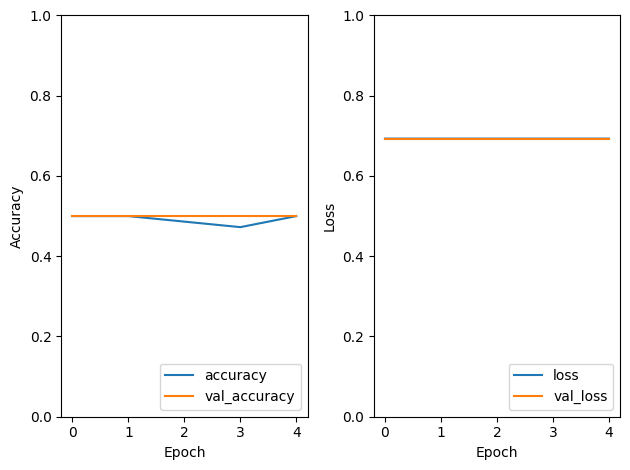

13/13 - 0s - loss: 0.6931 - accuracy: 0.5000 - 333ms/epoch - 26ms/step


In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)
ax[0].plot(history.history['accuracy'], label='accuracy')
ax[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([0,1])
ax[0].legend(loc='lower right')

ax[1].plot(history.history['loss'], label='loss')
ax[1].plot(history.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_ylim([0,1])
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)